In [20]:
import Utilities
from NaiveTCM import NaiveNetFitness
from PersistenceNetFitnessGlobal import PersistenceNetFitnessGlobal
from PersistenceNetFitness import PersistenceNetFitness
from PersistenceNetFitnesslinks import PersistenceNetFitnesslinks

import pandas as pd
import numpy as np
import networkx as nx
import os

import matplotlib.pyplot as plt
import seaborn as sns
import random

In [21]:
cd ../Structural Break and Reconstruction Social Networks/temporal_networks_daily

[Errno 2] No such file or directory: '../Structural Break and Reconstruction Social Networks/temporal_networks_daily'
/home/virginio.clemente/Structural Break and Reconstruction Social Networks/temporal_networks_daily


### Uploading the data

In [22]:
data = []

for file in os.listdir():
    if 'checkpoints' in file: continue
    step = int(file.split('_')[1].split('.')[0])
    matrix = np.genfromtxt(file,delimiter=',')
    G = nx.from_numpy_matrix(matrix)
    data.append([step , G ]) 

data.sort()

tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data,0,len(data))

pnt_likelihood_TCM = PersistenceNetFitness(tnet_synt_all)

### Reshuflling of the time order in the original Temporal Network

In [23]:
vec_h_null = np.zeros(92)

lista_vec_h_null = []
for iterations in range(100):
    def measured_autocorrelation(tgraph,tau):

        no_steps = len(tgraph.data)    
        no_nodes = len(tgraph.data[0][2].nodes()) 

        vec_h = np.zeros(no_nodes)        
        for i_step in range(no_steps+tau -1): 
            
            block_id, current_time , g0 = tgraph.data[ i_step%no_steps ]
            block_id, current_time , g1 = tgraph.data[ (i_step+tau)%no_steps ]
            for [n1,n2] in g0.edges():


                if g1.has_edge( n1,n2 ):
                    vec_h[int(n1)] += 1.
                    vec_h[int(n2)] += 1.

        vec_h /= float(no_steps+tau -1)

        h_ave = np.sum(vec_h)/len(vec_h)

        return np.asarray(vec_h),h_ave
    
    if iterations%50==0: print(iterations)
  
    tnet_shuffle = tnet_synt_all

    random.shuffle(tnet_shuffle.data)
    autocorrelazione_misurata,media = measured_autocorrelation(tnet_shuffle,1)


    lista_vec_h_null.append(autocorrelazione_misurata)
    vec_h_null += autocorrelazione_misurata

0
50


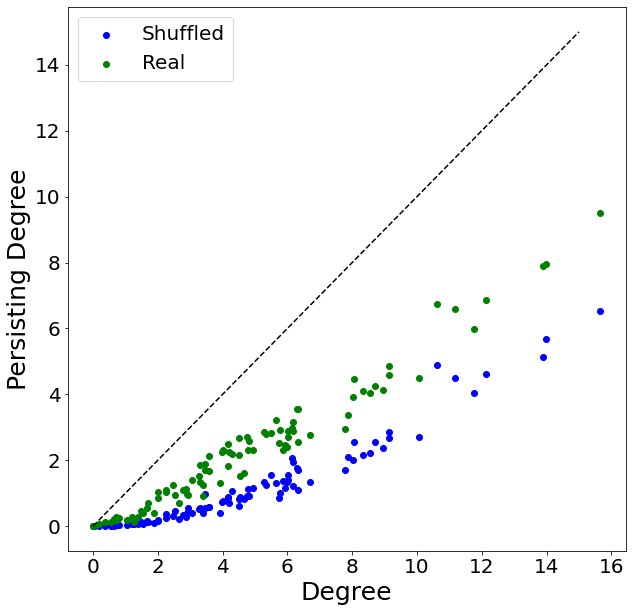

In [24]:
plt.figure(figsize=(10,10))

plt.scatter(x=pnt_likelihood_TCM.vec_k,y=vec_h_null/100 ,c='blue',label = 'Shuffled')

plt.scatter(x=pnt_likelihood_TCM.vec_k,y=pnt_likelihood_TCM.vec_h ,c='green',label = 'Real')

plt.plot([0, 15], [0, 15], ls="--", c="0")

plt.legend(fontsize=20)
plt.xlabel('Degree',fontsize=25)
plt.ylabel('Persisting Degree', fontsize=25)
plt.tick_params(axis='both', labelsize=20)  
plt.show()

# Here, I calculate the Mean Squared Error for various segments and determine the eigenvalues for the Model with local memory.

In [26]:
 def measured_autocorrelation(tgraph,tau):

    no_steps = len(tgraph.data)    
    no_nodes = len(tgraph.data[0][2].nodes()) 

    vec_h = np.zeros(no_nodes)        
    for i_step in range(no_steps+tau -1): 

        block_id, current_time , g0 = tgraph.data[ i_step%no_steps ]
        block_id, current_time , g1 = tgraph.data[ (i_step+tau)%no_steps ]
        for [n1,n2] in g0.edges():


            if g1.has_edge( n1,n2 ):
                vec_h[int(n1)] += 1.
                vec_h[int(n2)] += 1.

    vec_h /= float(no_steps+tau -1)

    h_ave = np.sum(vec_h)/len(vec_h)

    return np.asarray(vec_h),h_ave

In [27]:
class update_bjlambda:
    MIN_FITNESS = 1e-5 

    
    def __init__(self, tgraph, symmetric = True):
        self.verbose = False
        self.temp_graph = tgraph
        self.no_steps = len(self.temp_graph.data)
        self.no_nodes = len(self.temp_graph.data[0][2].nodes()) #int(tgraph.no_nodes) #
        
        self.fitness = np.ones( 2*self.no_nodes ,dtype=np.float64)
        
        self.symmetric = symmetric
        

        self.max_likelihood = -1e20

        self.B = np.zeros( (self.no_nodes,self.no_nodes),dtype=np.float64)
        self.J = np.zeros( (self.no_nodes,self.no_nodes),dtype=np.float64)
        self.lambda_minus = np.zeros( (self.no_nodes,self.no_nodes),dtype=np.float64)
        self.lambda_plus = np.zeros( (self.no_nodes,self.no_nodes),dtype=np.float64)

             
        self.compute(self.fitness)

        
    def compute(self, fitness):
        alpha = fitness[:self.no_nodes] 
        beta = fitness[self.no_nodes:] 
        
        for i in range(self.no_nodes):
            for j in range(i,self.no_nodes):
                ai = alpha[i]
                aj = alpha[j]
                bi = beta[i]
                bj = beta[j]
                
                self.B[i,j] = - 0.5 * (ai+aj+bi+bj)  / float(self.no_steps)
                self.B[j,i] = self.B[i,j]                
                self.J[i,j] = - 0.25 * (bi+bj)  / float(self.no_steps)
                self.J[j,i] = self.J[i,j]                


        lambda_term1 = np.cosh(self.B, dtype=np.float128)*np.exp(self.J, dtype=np.float128)
        lambda_term2 = np.sqrt( np.exp(2*self.J, dtype=np.float128)*np.sinh(self.B, dtype=np.float128)**2 + np.exp(-2*self.J, dtype=np.float128) , dtype=np.float128 )

        self.lambda_plus = lambda_term1 + lambda_term2
        self.lambda_minus = lambda_term1 - lambda_term2
    
        
        return self.lambda_plus,self.lambda_minus



def estimated_autocorrelation_TCM(tnet,x,y,tau):
    
    pnt = update_bjlambda(tnet,True)
    
    h_exp =  np.zeros( tnet.no_nodes )

    T = pnt.no_steps 

    g = [-T*np.log(ii) for ii in np.concatenate((x,y))]
    lambda_plus,lambda_minus = pnt.compute(g)  
    
    
    for i in range(pnt.no_nodes):
        for j in range(pnt.no_nodes):
            if i == j:
                continue

            root = np.sqrt(np.exp(-1*(np.log(y[i]) + np.log(y[j]))) + np.sinh(1/(2)*(np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))**2 )                   
            sinhB = np.sinh(1/(2) * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))
            
            coshB = np.cosh(1/(2) * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))

            e_2B = np.exp(-1 * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))
            e_B = np.exp(-1/2 * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))

            eJ = np.exp(1/(4)*(np.log(y[i]) + np.log(y[j])))


            sigma_l_t = (sinhB) / ( 2*root) + 1/2 
            
            h_exp [i] += sigma_l_t**2 + (1-sigma_l_t)*sigma_l_t*(lambda_minus[i,j]**tau*lambda_plus[i,j]**(T-tau) + lambda_plus[i,j]**tau*lambda_minus[i,j]**(T-tau) )/(lambda_minus[i,j]**T + lambda_plus[i,j]**T ) # N.T.L.


    h_ave = np.sum(h_exp)/len(h_exp)
    return h_exp,h_ave


In [28]:
alfa_rand = np.random.rand(92) 
beta_rand = np.random.rand(92) 


beta_random_link =np.random.rand(46*91) 
beta_random_global =np.random.rand(1) 

In [29]:
# This are the three segments indicated with T1,T2 and T3 in the main paper.
list_to_consider = [[36,43],[77,99],[193,214]]

In [30]:
input_TNC = data[36:43]

tnet_TNC = Utilities.TemporalNetworkLoaderSynt(input_TNC,0,len(input_TNC))

    
pnt_likelihood_local = PersistenceNetFitness(tnet_TNC)
pnt_likelihood_global = PersistenceNetFitnessGlobal(tnet_TNC)


likelihood_global = pnt_likelihood_global.solve(alfa_rand,beta_random_global)

likelihood_local = pnt_likelihood_local.solve(alfa_rand,beta_rand)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [31]:
y_local = pnt_likelihood_local.fitness_y
x_local = pnt_likelihood_local.fitness_x

x_global = pnt_likelihood_global.fitness_x
y_global = pnt_likelihood_global.fitness_y

y_global_list = [y_global[0]]*len(x_global)

y_global_list = np.asarray(y_global_list)

In [32]:
input_data_cm = data

tnet_cm = Utilities.TemporalNetworkLoaderSynt(input_data_cm,0,len(input_data_cm))

pnt_likelihood_CM = NaiveNetFitness(tnet_cm)

x_cm =  pnt_likelihood_CM.solve_eq()

`gtol` termination condition is satisfied.
Function evaluations 12, initial cost 8.7649e+03, final cost 2.8775e-10, first-order optimality 7.87e-07.
`gtol` termination condition is satisfied.


In [33]:
h_exp =  np.zeros( pnt_likelihood_CM.no_nodes )
         
for i_node in range( pnt_likelihood_CM.no_nodes ):
    for j_node in range( pnt_likelihood_CM.no_nodes ):
        if i_node == j_node: 
            continue
            
        prod = x_cm[i_node] * x_cm[j_node ]

        h_exp[ i_node ] += (prod / (1 + prod)) ** 2 

In [34]:
# For the dyadic part I am considering the point plus 50 snapshots. +
data_dyadic = data[36:86]

tnet_dyadic = Utilities.TemporalNetworkLoaderSynt(data_dyadic,0,len(data_dyadic))

pnt_likelihood_dyadic = PersistenceNetFitnesslinks(tnet_dyadic) 

pnt_likelihood_dyadic.solve(alfa_rand,beta_random_link)

/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:194: RuntimeWarning: overflow encountered in double_scalars
  t_sum_alfa += (T * (
/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:194: RuntimeWarning: invalid value encountered in double_scalars
  t_sum_alfa += (T * (
/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:215: RuntimeWarning: overflow encountered in double_scalars
  t_sum_beta = (T * (
/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:215: RuntimeWarning: invalid value encountered in double_scalars
  t_sum_beta = (T * (


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


41087.96432846162

In [35]:
n_nodes =  pnt_likelihood_dyadic.no_nodes

y_link = pnt_likelihood_dyadic.fitness_y 
y_matrix = np.zeros((n_nodes,n_nodes))


ij = 0
for i in range(n_nodes):
    for j in range(i):
        
        y_matrix[i,j] = y_link[ij]
        y_matrix[j,i] = y_matrix[i,j]

        ij +=1

In [38]:
x = pnt_likelihood_dyadic.fitness_x 

h_exp_link =  np.zeros( n_nodes )


T = pnt_likelihood_dyadic.no_steps

# Value of tau to modify to compute autocorrelation at higher level.
tau = 3



lambda_minus = pnt_likelihood_dyadic.lambda_minus 
lambda_plus = pnt_likelihood_dyadic.lambda_plus
for i in range(n_nodes):
    for j in range(n_nodes):
        if i == j:
            continue
          
        y_ij = y_matrix[i,j]
        root = np.sqrt(np.exp(-1*(np.log(y_ij) ), dtype=np.float128) + np.sinh(1/(2)*(np.log(x[i])+np.log(x[j], dtype=np.float128) +np.log(y_ij, dtype=np.float128) ))**2, dtype=np.float128 )                   
        sinhB = np.sinh(1/(2) * (np.log(x[i], dtype=np.float128)+np.log(x[j], dtype=np.float128) +np.log(y_ij, dtype=np.float128) ), dtype=np.float128)

        coshB = np.cosh(1/(2) * (np.log(x[i])+np.log(x[j]) +np.log(y_ij) ), dtype=np.float128)

        e_2B = np.exp(-1 * (np.log(x[i])+np.log(x[j]) +np.log(y_ij)), dtype=np.float128)
        e_B = np.exp(-1/2 * (np.log(x[i])+np.log(x[j]) +np.log(y_ij)), dtype=np.float128)

        eJ = np.exp(1/(4)*(np.log(y_ij, dtype=np.float128)), dtype=np.float128)

        sigma_l_t = (sinhB) / ( 2*root) + 1/2 


        h_exp_link [i] += sigma_l_t**2 + (1-sigma_l_t)*sigma_l_t*(lambda_minus[i,j]**tau*lambda_plus[i,j]**(T-tau) + lambda_plus[i,j]**tau*lambda_minus[i,j]**(T-tau) )/(lambda_minus[i,j]**T + lambda_plus[i,j]**T ) # N.T.L.


        

estimated_local,mean_l = estimated_autocorrelation_TCM(tnet_TNC,x_local,y_local,tau)

estimated_global,mean_g = estimated_autocorrelation_TCM(tnet_TNC,x_global,y_global_list,tau)
        
autocorrelazione_misurata,media = measured_autocorrelation(tnet_TNC,tau)

In [39]:
from sklearn.metrics import mean_squared_error

print( mean_squared_error(autocorrelazione_misurata, h_exp) ,' memory-less')

print( mean_squared_error(autocorrelazione_misurata,  estimated_local) ,' memory local')

print( mean_squared_error(autocorrelazione_misurata, estimated_global) ,' memory global')

print( mean_squared_error(autocorrelazione_misurata, h_exp_link) ,'memory dyadic')

7.458281405187302  memory-less
1.2522725764407365  memory local
1.4595134031564267  memory global
3.7301776685444623 memory dyadic


# Detection of Structural Breaks in Different Models with Memory

### I choose the number of cores to use in parallel for detecting structural breaks.

In [1]:
import multiprocessing

pool = multiprocessing.Pool(processes=12)

Set the initial values of the parameters depending on the model employed.

In [5]:
alfa_all = np.random.rand(92) 
beta_all = np.random.rand(92) 

beta_global = np.random.rand(1) 

alfa_all_link = np.random.rand(92) 
beta_all_link =np.random.rand(46*91) 

# Structural Breaks: General Algorithm 

Here is proposed an examle using model with local constraints.

To use others models change the class PersistenceNetFitness with PersistenceNetFitnessGlobal or PersistenceNetFitnesslinks, and change the number of parameters to consider in the AIC accodingly.

In [ ]:
class compute_likelihood():
    # Constructor to initialize the compute_likelihood object with data, alfa, and beta
    def __init__(self, data, alfa, beta):
        
        self.data = data  # Temporal network data
        self.alfa = alfa  # Alpha parameter
        self.beta = beta  # Beta parameter
     
    # Method to compute likelihood and AIC for the entire dataset
    def compute_likelihood_all(self):
        # Load the entire temporal network
        tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(self.data,0,len(self.data))
        
        # Calculate the likelihood for the whole network
        pnt_likelihood_all = PersistenceNetFitness(tnet_synt_all) 
        likelihood_all = pnt_likelihood_all.solve(self.alfa,self.beta)
    
        # Compute the AIC for the entire dataset
        AIC_all = Utilities.AIC(-likelihood_all,len(self.alfa) + len(self.beta))

        return AIC_all
    
    # Method to compute likelihood and AIC for the dataset split at a specific time point 't'
    def compute_likelihood_diff(self,t):
        
        # Load two sub-networks, one before and one after time 't'
        tnet_synt_0 = Utilities.TemporalNetworkLoaderSynt(self.data,0,t)
        tnet_synt_1 = Utilities.TemporalNetworkLoaderSynt(self.data,t,len(self.data))

        # Calculate the likelihood for each sub-network
        pnt_likelihood_0 = PersistenceNetFitness(tnet_synt_0)
        pnt_likelihood_1 = PersistenceNetFitness(tnet_synt_1)
        likelihood_0 = pnt_likelihood_0.solve(self.alfa,self.beta)
        likelihood_1 = pnt_likelihood_1.solve(self.alfa,self.beta)    

        # Compute the AIC for the two sub-networks combined
        AIC_diff = Utilities.AIC(-likelihood_0-likelihood_1,(len(self.alfa) + len(self.beta))*2)
        
        return AIC_diff
    
    


In [ ]:
def find_breaks(last_increment, last_t_break, data):
    to_continue= True # Control flag for the while loop

    while to_continue:
        # Calculate the candidate break point
        candidate_break = last_t_break + last_increment

        # Select the segment of data up to the candidate break point
        data_input = data[last_t_break:candidate_break] 
        
        # Create a range to test different split points within the segment
        t_vec = list(range(3,len(data_input)-2)) 

        # Initialize the likelihood computation with the current data segment
        p_likelihood = compute_likelihood(data_input,alfa_all,beta_all)

        # Compute the likelihood for the entire segment
        lik_all = p_likelihood.compute_likelihood_all()

        # Compute the likelihood differences for various split points in parallel
        outputs = pool.map(p_likelihood.compute_likelihood_diff, t_vec)

        # Find the split point with the minimum likelihood difference
        arg_min = np.argmin(np.asarray(outputs) - lik_all)

        # Check if no break point is found in the current segment
        if np.asarray(outputs)[arg_min]> lik_all:
            to_continue = False
            
            # Check if the last increment is different from the last break point
            if last_increment != last_t_break:
                return last_increment
            
            else:
                # Error condition when no further break point can be found
                print('\nNo Breaks\n')
                return 'Errore'

        # Check if the minimum arg is too close to the start of the segment
        if arg_min < 3:
            print(arg_min + 3)
            to_continue = False

        # Update the last increment for the next iteration
        last_increment = arg_min + 3
     

    return (last_increment)

In [ ]:
# Initialize parameters
last_increment = 50  # Set initial increment
n_snapshots = 244  # Total number of snapshots in the time series
last_t_break = 0  # Set the initial break position

# Initialize the list of found break points, starting from 0
found_breaks = [0]

# Continue the loop until the last found break point exceeds the total number of snapshots
while (found_breaks[len(found_breaks)-1] + 3) < n_snapshots:
    
    # Find the next break point using the find_breaks function
    last_t_break = find_breaks(last_increment,last_t_break,data)

    # Update the last break position based on the latest break found
    last_t_break = found_breaks[len(found_breaks)-1] + last_t_break
    # Append the latest break point to the list
    found_breaks.append(last_t_break)
    
    # Adjust the increment based on the remaining distance to the end of the data
    if n_snapshots - last_t_break < 50:
        last_increment = n_snapshots - last_t_break   
    else:
        last_increment = 50
    
    # Print the current list of found break points
    print(found_breaks)

In [ ]:
local_breaks = [0, 8, 15, 19, 24, 36, 43, 49, 61, 77, 99, 109, 116, 126, 143, 150, 165, 177, 193, 214, 231, 244]

In [ ]:
global_breaks = [0, 8, 15, 18, 24, 31, 36, 43, 49, 60, 63, 68, 77, 99, 109, 116, 126, 134, 142, 150, 165, 177, 193, 214, 231, 244]

In [25]:
dyadic_breaks = [0, 50, 100, 150, 200, 244]